#git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Deep Learning/final_project/20242R0136COSE47402

/content/drive/MyDrive/Deep Learning/final_project/20242R0136COSE47402


In [ ]:
!git config --global user.email 'robosun78@korea.ac.kr'
!git config --global user.name 'robosun78'

In [ ]:
!ls

FinalProject  HW1  HW2	HW3  HW4  README.md


In [ ]:
!git add FinalProject

In [ ]:
!git commit -m 'CLIP&DINOv2 implement'
!git push

[main 88f0717] CLIP&DINOv2 implement
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite FinalProject/Final_proejct_2022320027.ipynb (98%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 8 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 11.37 KiB | 1.42 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/robosun78/20242R0136COSE47402.git
   fa8d7f5..88f0717  main -> main


#Code

In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 46.6 MB/s eta 0:00:00


In [2]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3


In [3]:
import torch
import torchvision
from transformers import AutoModel, AutoImageProcessor
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import faiss
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

## Dataset

In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hmendonca/disc21")

print("Path to dataset files:", path)

KeyboardInterrupt: 

In [ ]:
import pandas as pd

data_df = pd.read_csv("/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/final_ground_truth.csv")

In [4]:
data_df = pd.DataFrame({
    "query": ["Q50017"] + data_df['Q50017'].tolist(),
    "reference": ["R277156"] + data_df['R277156'].tolist()
})

In [5]:
import os
query_folder_path = "/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/final_queries/images/final_queries"
reference_folder_path = "/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/references_0/images/references"
# 파일 개수 세기
file_count = len([file for file in os.listdir(reference_folder_path) if os.path.isfile(os.path.join(reference_folder_path, file))])

print(f"Number of files in the folder: {file_count}")

Number of files in the folder: 50000


In [7]:
data_df['numeric_reference'] = data_df['reference'].str.extract(r'R(\d+)').astype(int)

In [8]:
filtered_df = data_df[data_df['numeric_reference']<=50000]

In [9]:
query_list = filtered_df['query'].tolist()
reference_list = filtered_df['reference'].tolist()

In [10]:
filtered_df

,query,reference,numeric_reference
12,Q50060,R003513,3513
19,Q50095,R029638,29638
34,Q50186,R038042,38042
44,Q50229,R040485,40485
77,Q50386,R037975,37975
...,...,...,...
9909,Q99525,R030731,30731
9912,Q99538,R043554,43554
9956,Q99763,R034725,34725
9985,Q99915,R044043,44043


##CLIP

In [15]:
from transformers import AutoProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [17]:
reference_image = []
for file in tqdm(reference_list):
    image = Image.open(os.path.join(reference_folder_path,file+'.jpg'))
    image = clip_processor(images = image, return_tensors="pt").pixel_values
    reference_image.append(image)
reference_loader = torch.utils.data.DataLoader(reference_image, batch_size=32)

100%|██████████| 500/500 [00:21<00:00, 23.56it/s]


In [ ]:
query_images = []
for file in tqdm(query_list):
    image = Image.open(os.path.join(query_folder_path,file+'.jpg'))
    image = clip_processor(images = image, return_tensors="pt").pixel_values
    query_images.append(image)
query_loader = torch.utils.data.DataLoader(query_images, batch_size=32)

In [16]:
def extract_features_clip(image):
  with torch.no_grad():
      inputs_clip = clip_processor(images=image, return_tensors="pt").pixel_values
      image_features_clip = clip_model.get_image_features(inputs_clip)
      return image_features_clip

## DinoV2

In [4]:
from transformers import AutoImageProcessor, AutoModel

#dinov2_ = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14")
dino_model = AutoModel.from_pretrained('facebook/dinov2-base')
dino_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

In [5]:
test_img='/content/CAR_IMAGE.jpg'
test_img = Image.open(test_img)

In [7]:
reference_image=[]

test_list = ['/content/CAR_IMAGE.jpg']
for file in tqdm(test_list):
    image = Image.open(file)
    image = dino_processor(images = image, return_tensors="pt").pixel_values
    reference_image.append(image)
reference_loader = torch.utils.data.DataLoader(reference_image, batch_size=128)

100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


In [ ]:
reference_image = []
for file in tqdm(reference_list):
    image = Image.open(os.path.join(reference_folder_path,file+'.jpg'))
    image = dino_processor(images = image, return_tensors="pt").pixel_values
    reference_image.append(image)
reference_loader = torch.utils.data.DataLoader(reference_image, batch_size=128)

In [ ]:
query_images = []
for file in tqdm(query_list):
    image = Image.open(os.path.join(query_folder_path,file+'.jpg'))
    image = dino_processor(images = image, return_tensors="pt").pixel_values
    query_images.append(image)
query_loader = torch.utils.data.DataLoader(query_images, batch_size=64)

In [8]:
def extract_features_dino(image):
  with torch.no_grad():
      #inputs_dino = dino_processor(images=image, return_tensors="pt").to(device)
      #outputs_dino = dino_model(**inputs_dino)
      image_features_dino = outputs_dino.last_hidden_state
      image_features_dino = image_features_dino.mean(dim=1)
      return image_features_dino

## ViT

In [15]:
from transformers import AutoImageProcessor, ViTModel

vit_model = ViTModel.from_pretrained("google/vit-large-patch16-224-in21k")
vit_processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [16]:
def extract_features_vit(image):
  with torch.no_grad():
      inputs_vit = vit_processor(images=image, return_tensors="pt").to(device)
      outputs_vit = vit_model(**inputs_vit)
      image_features_vit = outputs_vit.last_hidden_state[:, 0, :].squeeze(1)
      return image_features_vit

# Simiarity

## image embeddings

In [11]:
def normalizeL2(embeddings):
    vector = embeddings.detach().cpu().numpy()
    vector = np.float32(vector)
    faiss.normalize_L2(vector)
    return vector

In [12]:
def make_embeddings(embedding, index):
    vector = embedding.detach().cpu().numpy()
    vector = np.float32(vector)
    faiss.normalize_L2(vector)
    index.add(vector)

In [9]:
index_clip = faiss.IndexFlatL2(512)
index_dino = faiss.IndexFlatL2(768)
index_vit = faiss.IndexFlatL2(1024)

In [17]:
from tqdm import tqdm

for img in tqdm(reference_loader):
    #print(img.shape)
    clip_features = clip_model.get_image_features(img.squeeze(1))
    make_embeddings(clip_features,index_clip)
    dino_features = dino_model(img.squeeze(1)).last_hidden_state.mean(dim=1)
    make_embeddings(dino_features,index_dino)
    vit_features = vit_model(imgsqueeze(1)).last_hidden_state[:, 0, :].squeeze(1)
    make_embeddings(vit_features,index_vit)

100%|██████████| 1/1 [00:04<00:00,  4.16s/it]

torch.Size([1, 768])


In [18]:
#faiss.write_index(index_clip,"clip.index")
faiss.write_index(index_dino,"dino.index")
#faiss.write_index(index_vit,"vit.index")

## test

In [ ]:
test_img='/content/CAR_IMAGE.jpg'
test_img = Image.open(test_img)

In [27]:
#dino_features = extract_features_dino(test_img)
#image_features_dino = normalizeL2(dino_features)
#print(test_img.shape)
clip_features = extract_features_clip(test_img)
image_features_clip = normalizeL2(clip_features)
#vit_features = extract_features_vit(test_img)
#image_features_vit = normalizeL2(vit_features)

In [28]:
index_clip = faiss.read_index("clip.index")
#index_dino = faiss.read_index("dino.index")
#index_vit = faiss.read_index("vit.index")

In [29]:
index_clip.ntotal

500

In [30]:
#d_dino,i_dino = index_dino.search(image_features_dino,5)
d_clip,i_clip = index_clip.search(image_features_clip,5)
#d_vit,i_vit = index_vit.search(image_features_vit,5)

In [32]:
for idx, dist in zip(i_clip[0], d_clip[0]):
  print(idx)
  print(reference_list[idx], dist)

195
R046404 0.82766926
267
R011012 0.9006485
478
R045322 0.90620005
488
R019363 0.9105289
171
R029527 0.9157551


In [141]:
len(reference_list)

500

In [36]:
retrieved_images = [
    {"path": os.path.join(reference_folder_path,reference_list[idx]+'.jpg'), "similarity": 100 - dist* 100} for idx, dist in zip(i_clip[0], d_clip[0])
]

In [37]:
retrieved_images

[{'path': '/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/references_0/images/references/R046404.jpg',
  'similarity': 17.233073711395264},
 {'path': '/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/references_0/images/references/R011012.jpg',
  'similarity': 9.935152530670166},
 {'path': '/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/references_0/images/references/R045322.jpg',
  'similarity': 9.379994869232178},
 {'path': '/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/references_0/images/references/R019363.jpg',
  'similarity': 8.947110176086426},
 {'path': '/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/references_0/images/references/R029527.jpg',
  'similarity': 8.424490690231323}]

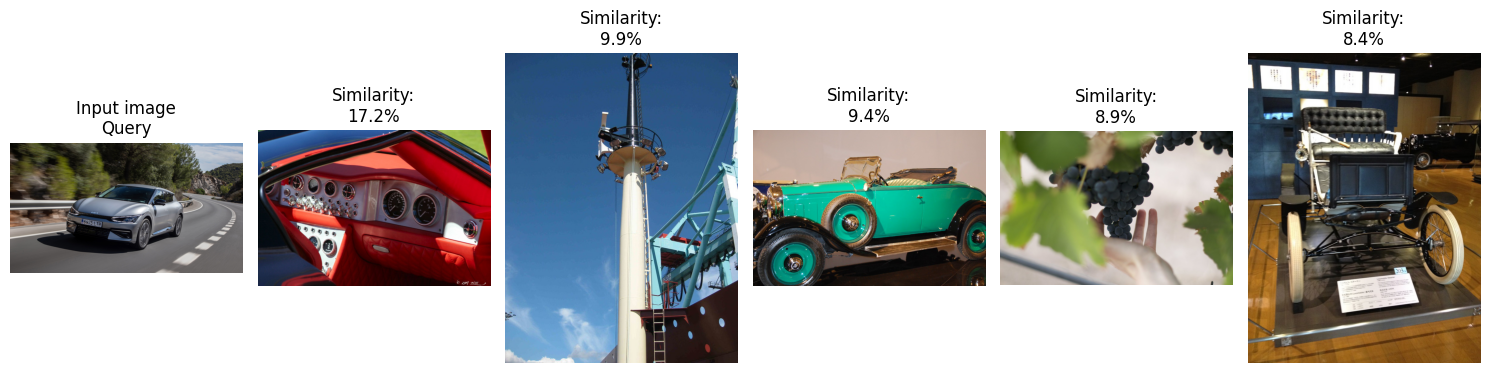

In [40]:
def visualize_similar_images(query_image, retrieved_images):
    # 쿼리 이미지 로드

    # 설정: 시각화 크기
    fig, axes = plt.subplots(1, len(retrieved_images) + 1, figsize=(15, 5))

    # 쿼리 이미지 표시
    axes[0].imshow(query_image)
    axes[0].axis("off")
    axes[0].set_title("Input image\nQuery")

    # 검색된 이미지 표시
    for i, img_info in enumerate(retrieved_images):
        # 이미지 로드
        img = Image.open(img_info["path"]).convert("RGB")
        similarity = img_info["similarity"]

        # 이미지 표시
        axes[i + 1].imshow(img)
        axes[i + 1].axis("off")
        axes[i + 1].set_title(f"Similarity:\n{similarity:.1f}%")

    plt.tight_layout()
    plt.show()

# 5. 함수 호출
visualize_similar_images(test_img, retrieved_images)

## evaluate

In [ ]:
distance_list = []
index_list=[]

for batch in tqdm(query_loader):
  clip_features = clip_model.get_image_features(img.squeeze(1))
  print(clip_features.shape)
  image_features_clip = normalizeL2(clip_features)
  index_clip = faiss.read_index("clip.index")
  d_clip,i_clip = index_clip.search(image_features_clip,3)
  print(d_clip.shape)
  distance_list.append(d_clip[0])
  index_list.append(i_clip[0])

  0%|          | 0/16 [00:00<?, ?it/s]

In [51]:
filtered_df

,query,reference,numeric_reference
12,Q50060,R003513,3513
19,Q50095,R029638,29638
34,Q50186,R038042,38042
44,Q50229,R040485,40485
77,Q50386,R037975,37975
...,...,...,...
9909,Q99525,R030731,30731
9912,Q99538,R043554,43554
9956,Q99763,R034725,34725
9985,Q99915,R044043,44043


In [63]:
query_list[1], distance_list[0], index_list[0]


('Q50095',
 array([0.        , 0.32509184, 0.42825532], dtype=float32),
 array([480,  57, 453]))

In [64]:
for idx, dist in zip(index_list[1],  distance_list[1]):
  print(idx)
  print(reference_list[idx], dist)

480
R001561 0.0
57
R015775 0.32509184
453
R015732 0.42825532


In [58]:
retrieved_images = [
    {"path": os.path.join(reference_folder_path,reference_list[idx]+'.jpg'), "similarity": 100 - dist* 100} for idx, dist in zip(index_list[1], distance_list[1])
]

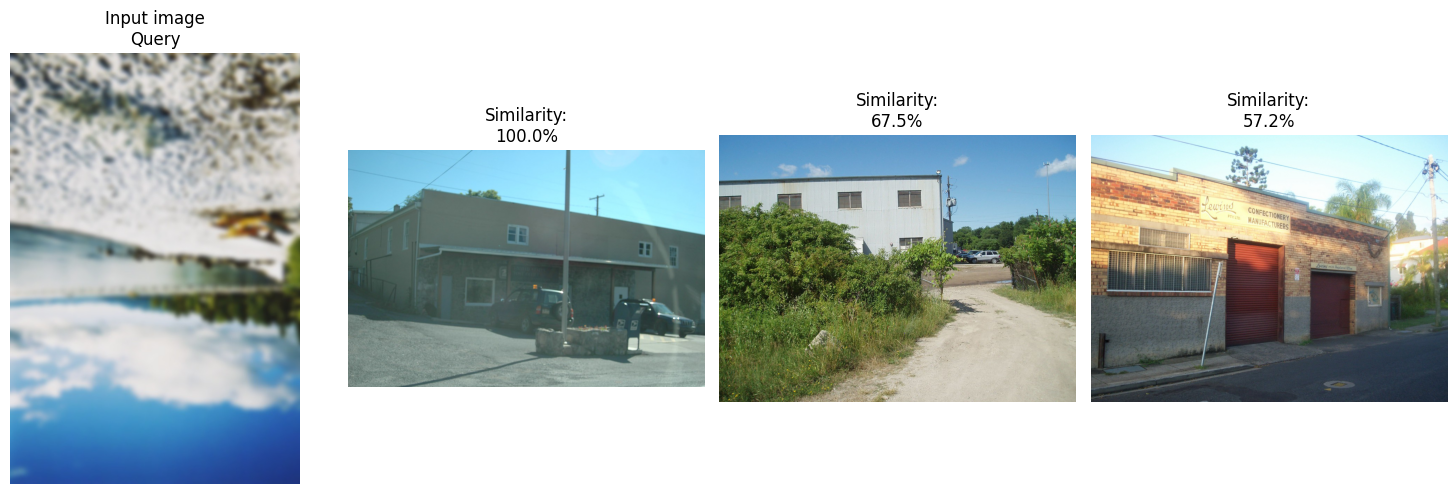

In [59]:
test_img = os.path.join(query_folder_path,query_list[0]+'.jpg')
test_img = Image.open(test_img)
visualize_similar_images(test_img, retrieved_images)

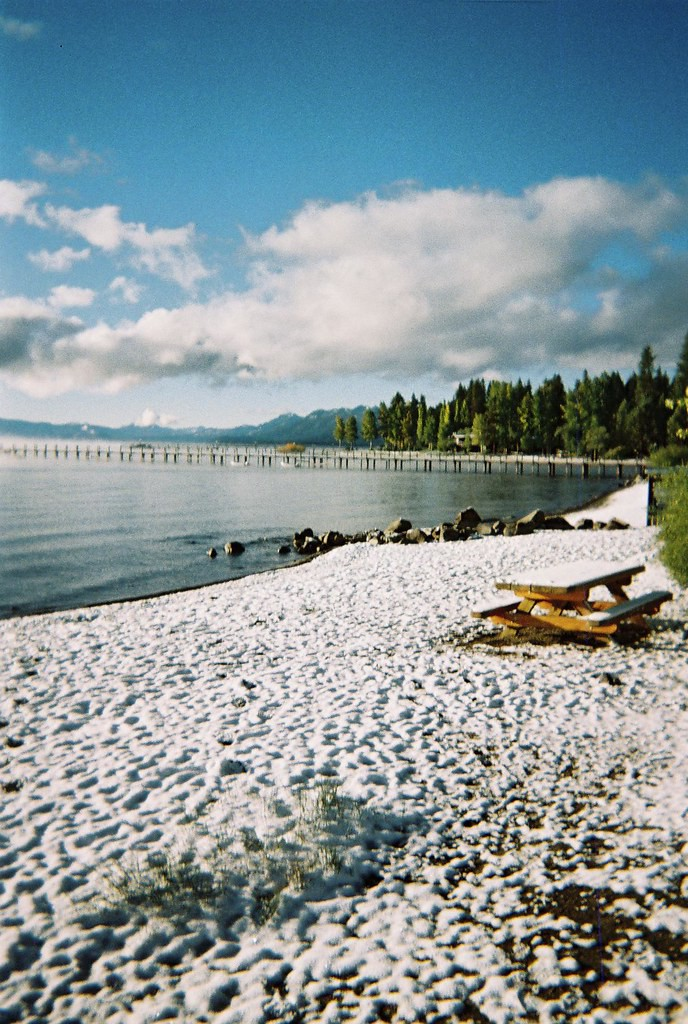

In [61]:
 tmp = os.path.join(reference_folder_path,'R003513.jpg')
 tmp = Image.open(tmp)
 tmp